In [38]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
import plotly.graph_objects as go
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
##from wordcloud import WordCloud
import pandas as pd
import matplotlib as plt 
import numpy as np
from sklearn import metrics, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from mlxtend.plotting import plot_confusion_matrix
import plotly.express as px
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from nltk import PorterStemmer, WordNetLemmatizer
from keras.models import Sequential ##form our layers 
from keras.layers import Dense, Dropout## this helps us with overfitting
from mlxtend.plotting import plot_confusion_matrix
import streamlit as st


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
###Random Forest performs better than Logistic Reression and SVM. 

In [42]:
## load the data
df = pd.read_csv("news_articles.csv")


In [39]:
## change the display format of the column
pd.options.display.float_format = '{:.2f}'.format
df.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.00
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.00
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.00
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.00
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.00


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2096 non-null   object 
 1   published                2096 non-null   object 
 2   title                    2096 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2095 non-null   object 
 5   site_url                 2095 non-null   object 
 6   main_img_url             2095 non-null   object 
 7   type                     2095 non-null   object 
 8   label                    2095 non-null   object 
 9   title_without_stopwords  2094 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2095 non-null   float64
dtypes: float64(1), object(11)
memory usage: 196.6+ KB


In [18]:
df.keys()

Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'label', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage'],
      dtype='object')

In [70]:
df.shape

(2096, 12)

In [71]:
df['label'].value_counts()
##the data is a bit imbalanced

Fake    1294
Real     801
Name: label, dtype: int64

In [74]:
df['site_url'].value_counts()

wnd.com                  100
presstv.ir               100
frontpagemag.com         100
infowars.com             100
clickhole.com            100
                        ... 
madworldnews.com           1
barenakedislam.com         1
intrepidreport.com         1
defenddemocracy.press      1
globalresearch.ca          1
Name: site_url, Length: 68, dtype: int64

In [79]:
df['hasImage'].value_counts()

1.00    1628
0.00     467
Name: hasImage, dtype: int64

In [82]:
df.groupby(['hasImage'])['label'].value_counts()

hasImage  label
0.00      Fake     341
          Real     126
1.00      Fake     953
          Real     675
Name: label, dtype: int64

In [72]:
###df.groupby(['label'])['type'].sum()

label
Fake    conspiracyconspiracyconspiracyconspiracyconspi...
Real    biasbiasbiasbiasbiasbiasbiasbiasbiasbiasbiasbi...
Name: type, dtype: object

In [78]:
df.groupby(['label'])['type'].value_counts()

label  type      
Fake   bs            601
       conspiracy    430
       satire        146
       junksci       102
       fake           15
Real   bias          436
       hate          244
       state         121
Name: type, dtype: int64

In [73]:
df.groupby(['label'])['language'].value_counts()

label  language
Fake   english     1220
       german        72
       french         1
       spanish        1
Real   english      797
       ignore         3
       french         1
Name: language, dtype: int64

In [39]:
df.groupby(['label'])['author'].value_counts()

label  author                             
Fake   No Author                              329
       Activist Post                           82
       noreply@blogger.com (Der Postillon)     72
       Anonymous                               58
       admin                                   48
                                             ... 
Real   William Adams                            1
       Yrag Werdna Xuaedobiht                   1
       davidduke.com                            1
       reasoning with facts                     1
       wtromp@operamail.com (WT)                1
Name: author, Length: 503, dtype: int64

In [76]:
df['language'].value_counts()

english    2017
german       72
ignore        3
french        2
spanish       1
Name: language, dtype: int64

In [17]:
df['type'].value_counts()

bs            601
bias          436
conspiracy    430
hate          244
satire        146
state         121
junksci       102
fake           15
Name: type, dtype: int64

In [24]:
df['author'].value_counts()

No Author                              505
Activist Post                           82
EdJenner                                73
noreply@blogger.com (Der Postillon)     72
Anonymous                               58
                                      ... 
Frontpagemag.com                         1
Phyllis Chesler                          1
Emma-Kate Symons                         1
Ilana Mercer                             1
Eddy Lavine                              1
Name: author, Length: 491, dtype: int64

In [18]:
i=df.type.value_counts()

In [19]:
fig=go.Figure(data=[go.Bar(x=['bs','bias','conspiracy','hate','satire', 'state', 'junksci','fake'], y=i,text=i,textposition='auto')])
fig.show()
##bs=bullshit

In [3]:
i=df.label.value_counts()

In [5]:
fig=go.Figure(data=[go.Bar(x=['Real','Fake'], y=i,text=i,textposition='auto')])
fig.show()

In [15]:
i=df.language.value_counts()

In [16]:
fig=go.Figure(data=[go.Bar(x=['English','German', 'French', 'Spanish', 'Others'], y=i,text=i,textposition='auto')])
fig.show()

In [20]:
df.groupby(['label','type'], as_index=False)['language'].sum()

,label,type,language
0,Fake,bs,englishenglishenglishenglishenglishenglishengl...
1,Fake,conspiracy,englishenglishenglishenglishenglishenglishengl...
2,Fake,fake,englishenglishenglishenglishenglishenglishengl...
3,Fake,junksci,englishenglishenglishenglishenglishenglishengl...
4,Fake,satire,englishenglishenglishenglishenglishenglishengl...
5,Real,bias,englishenglishenglishenglishenglishenglishengl...
6,Real,hate,englishenglishenglishenglishenglishenglishengl...
7,Real,state,englishenglishenglishenglishfrenchenglishengli...


C:\Users\brill\AppData\Local\Temp\ipykernel_6876\56320291.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



<AxesSubplot: xlabel='language'>

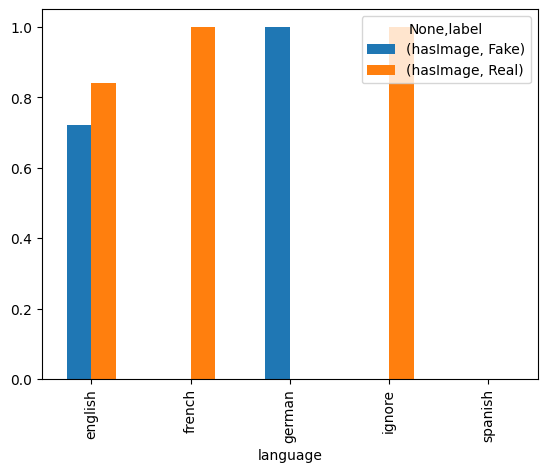

In [21]:
df.pivot_table(index='language', columns='label').plot(kind='bar')

C:\Users\brill\AppData\Local\Temp\ipykernel_6876\2089503313.py:1: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



<AxesSubplot: xlabel='type'>

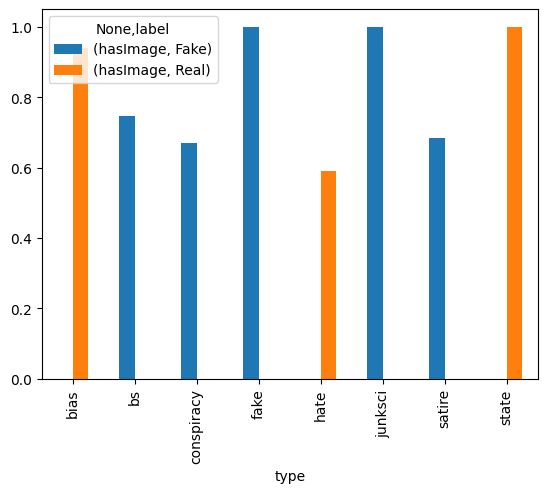

In [22]:
df.pivot_table(index='type', columns='label').plot(kind='bar')

In [234]:
##preprocessing the data 
##defining null values 

In [43]:
df.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

In [45]:
##filling null values with previous value
df_news=df.fillna(method='pad')



In [46]:
df_news.isnull().sum()

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
label                      0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
dtype: int64

In [47]:
##dropping columns 
df_news.drop(['published'], axis=1,inplace=True)
df_news.drop(['title'], axis=1,inplace=True)
df_news.drop(['title_without_stopwords'], axis=1,inplace=True)

In [8]:
df_news.head(5)

,author,text,language,site_url,main_img_url,type,label,text_without_stopwords,hasImage
0,Barracuda Brigade,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,red state fox news sunday reported morning ant...,1.0
3,Fed Up,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,email healthcare reform make america great sin...,1.0


In [8]:
df_news.keys()

Index(['author', 'text', 'language', 'site_url', 'main_img_url', 'type',
       'label', 'text_without_stopwords', 'hasImage'],
      dtype='object')

In [48]:
##dropping duplicates 

df_news.duplicated('text').sum()

155

In [49]:
df_news.duplicated('text_without_stopwords').sum()

159

In [50]:
df_news.drop_duplicates(subset=['text','text_without_stopwords'],keep=False, inplace=True)

In [51]:
##removing puntuaction and symbols
import string 
def punctuation_removal(text): 
    all_list =[char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
df_news['text']=df_news['text'].apply(punctuation_removal)

In [13]:
##puntuaction removal
def punctuation_removal(text): 
    all_list =[char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str
df_news['text_without_stopwords']=df_news['text_without_stopwords'].apply(punctuation_removal)

In [52]:
punct=string.punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans("","",punct))

df_news ['text']=df_news['text'].apply(lambda x: remove_punctuation(x))

In [53]:
def remove_punctuation(x):
    return x.translate(str.maketrans("","",punct))

df_news ['text_without_stopwords']=df_news['text_without_stopwords'].apply(lambda x: remove_punctuation(x))

In [54]:

df_news['text_without_stopwords'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
df_news['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

C:\Users\brill\AppData\Local\Temp\ipykernel_3852\3374449997.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news['text_without_stopwords'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
C:\Users\brill\AppData\Local\Temp\ipykernel_3852\3374449997.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')


0       print they should pay all the back all the mon...
1       why did attorney general loretta lynch plead t...
2       red state  \nfox news sunday reported this mor...
3       email kayla mueller was a prisoner and torture...
4       email healthcare reform to make america great ...
                              ...                        
2044    wars and rumors of wars russia unveils satan  ...
2045    check out hillarythemed haunted house anticlin...
2046    good samaritan wearing indian headdress disarm...
2047    skype sex scam  a fortune built on shame moroc...
2048    posted by eddie while the skyhigh potency may ...
Name: text, Length: 1904, dtype: object

In [55]:

df_news['site_url'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

C:\Users\brill\AppData\Local\Temp\ipykernel_3852\1357786556.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news['site_url'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')


0       100percentfedup.com
1       100percentfedup.com
2       100percentfedup.com
3       100percentfedup.com
4       100percentfedup.com
               ...         
2044                wnd.com
2045                wnd.com
2046                wnd.com
2047                wnd.com
2048                wnd.com
Name: site_url, Length: 1904, dtype: object

In [56]:
df_news['main_img_url'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')

C:\Users\brill\AppData\Local\Temp\ipykernel_3852\172778232.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news['main_img_url'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')


0                   
1                   
2                   
3                   
4                   
            ...     
2044                
2045                
2046    No Image URL
2047                
2048                
Name: main_img_url, Length: 1904, dtype: object

In [57]:
df_news['text']=df_news['text'].str.replace(r"[\"\'\|\?\=\.\<\>\@\#\*\,]",'')

C:\Users\brill\AppData\Local\Temp\ipykernel_3852\2723401987.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_news['text']=df_news['text'].str.replace(r"[\"\'\|\?\=\.\<\>\@\#\*\,]",'')


In [58]:
def fn(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [59]:
df_news['text']=df_news['text'].apply(lambda x:fn(x))
df_news.head(3)

,author,text,language,site_url,main_img_url,type,label,text_without_stopwords,hasImage
0,Barracuda Brigade,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,red state fox news sunday reported this morni...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,red state fox news sunday reported morning ant...,1.0


In [270]:

##df_news=df_news[~df_news.main_img_url.str.contains("http")]
##df_news=df_news[~df_news.main_img_url.str.contains("HOST")]

In [57]:
df_news['text'][3]

'email kayla mueller was a prisoner and tortured by isis while no chance of releasea horrific story her father gave a pin drop speech that was so heartfelt you want to give him a hug carl mueller believes donald trump will be a great presidentepic speech k shares'

In [60]:
##lowercase

df_news['author']=df_news['author'].apply(lambda x: x.lower())
df_news['text']=df_news['text'].apply(lambda x: x.lower())
df_news['text_without_stopwords'].apply(lambda x: x.lower())
df_news['label']=df_news['label'].apply(lambda x: x.lower())



In [23]:
df_news.head()

,author,text,language,site_url,main_img_url,type,label,text_without_stopwords,hasImage
0,barracuda brigade,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,real,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,real,attorney general loretta lynch plead fifth bar...,1.0
2,barracuda brigade,red state fox news sunday reported this morni...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,real,red state fox news sunday reported morning ant...,1.0
3,fed up,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,real,email kayla mueller prisoner tortured isis cha...,1.0
4,fed up,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,real,email healthcare reform make america great sin...,1.0


In [ ]:
##df['clean_joined]=df['clean].apply(lambda x: " ".join(x))


In [61]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [62]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df_news['text'] = df_news['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [61]:
df_news['text'][3]

'email kayla mueller prisoner tortured isis chance releasea horrific story father gave pin drop speech heartfelt want give hug carl mueller believes donald trump great presidentepic speech k shares'

In [63]:
##tokenize
df_news['text'] = df_news.apply(lambda row: nltk.word_tokenize(row['text']),axis=1)




In [64]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemma(df_news):
    return[lemmatizer.lemmatize(w)for w in df_news]

df_news['text'] = df_news['text'].apply(lemma)



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [65]:
df_news.head(3)

,author,text,language,site_url,main_img_url,type,label,text_without_stopwords,hasImage
0,barracuda brigade,"[print, pay, back, money, plus, interest, enti...",english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,real,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,"[attorney, general, loretta, lynch, plead, fif...",english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,real,attorney general loretta lynch plead fifth bar...,1.0
2,barracuda brigade,"[red, state, fox, news, sunday, reported, morn...",english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,real,red state fox news sunday reported morning ant...,1.0


In [371]:
##def process_text(text):
    #new_text =text.lower()
    #new_text=re.sub(r'\s]+','dollar',new_text)
    #new_text=re.sub(r'[^a-z0-9\s]', '', new_text)
    #new_text=re.sub(r'[0-9]+', '',new_text)
    #new_text=new_text.split(" ")
    #new_text =list(map(lambda x: ps.stem(x).new_text)) 
    #new_text=list(map(lambda x: x.strip(). new_text))
    #if '' in new_text:
        #new_text.remove('')
    #return new_text


In [312]:
##def stemming(text):
    ##fn_text = re.sub('[^a-zA-Z]',' ',text)
    ##fn_text = fn_text.lower()
    ##fn_text = fn_text.split()
    ##fn_text = [port_stem.stem(word) for word in fn_text if not word in stopwords.words('english')]
    ##fn_text = ' '.join(fn_text)
    ##return fn_text

In [66]:
##preparing the data before splitting
## convert label column into numbers 
label_encoder=LabelEncoder()

df_news['label']= label_encoder.fit_transform(df_news['label']) 

In [67]:
df_news['label'].value_counts()##1 = real news and 0 = fake news

0    1156
1     748
Name: label, dtype: int64

In [68]:
df_news['type']= label_encoder.fit_transform(df_news['type']) 

In [69]:
df_news['type'].value_counts()

1    547
0    383
2    348
4    244
6    144
7    121
5    102
3     15
Name: type, dtype: int64

In [70]:
df_news['language']= label_encoder.fit_transform(df_news['language']) 

In [71]:
df_news['language'].value_counts()

0    1826
2      72
3       3
1       2
4       1
Name: language, dtype: int64

In [36]:
import matplotlib.pyplot as plt


<AxesSubplot: xlabel='label'>

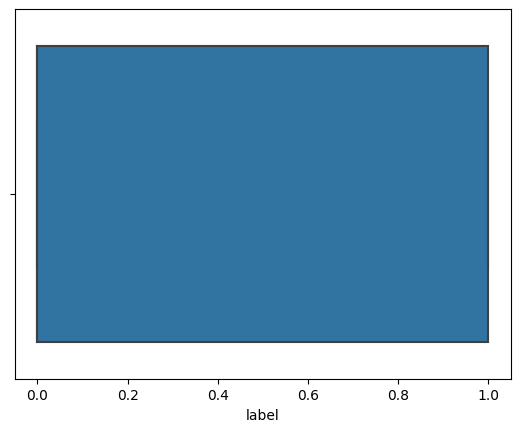

In [53]:
sns.boxplot(x= df_news['label'])

<AxesSubplot: xlabel='type'>

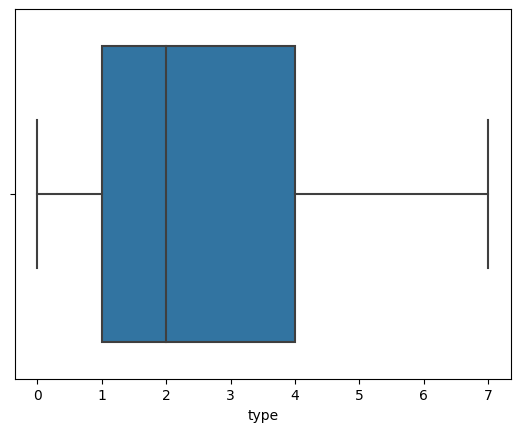

In [56]:
sns.boxplot(x= 'type',data=df_news)

In [54]:
df_news.describe()

,language,type,label,hasImage
count,1904.000000,1904.000000,1904.000000,1904.000000
mean,0.083508,2.355567,0.392857,0.782038
std,0.409890,2.183909,0.488514,0.412970
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,1.000000
50%,0.000000,2.000000,0.000000,1.000000
75%,0.000000,4.000000,1.000000,1.000000
max,4.000000,7.000000,1.000000,1.000000


<AxesSubplot: ylabel='label'>

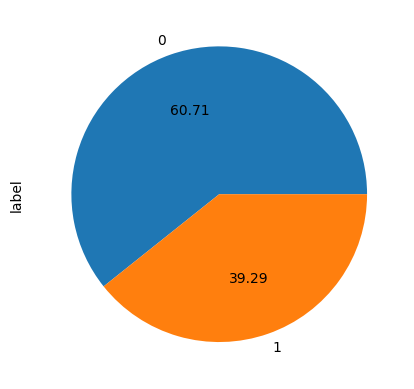

In [72]:
##Balance de data 
##as I mentioned above the data is imbalanced. 
## I have decided to balance the data
df_news['label'].value_counts().plot.pie(autopct='%.2f')

In [73]:
df['label'].value_counts()

Fake    1294
Real     801
Name: label, dtype: int64

In [74]:
from imblearn.over_sampling import RandomOverSampler

In [75]:
X=df_news.drop(['label'], axis=1)
y=df_news['label']

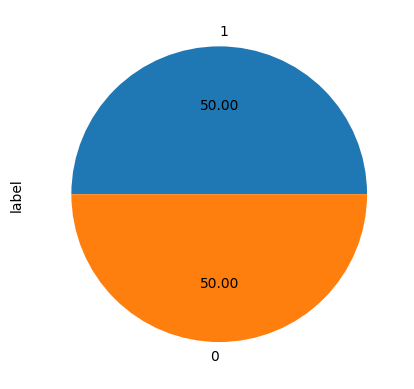

In [76]:
ros = RandomOverSampler(sampling_strategy='not majority')
X_res, y_res =ros.fit_resample(X, y)
ax = y_res.value_counts().plot.pie(autopct='%.2f') 

In [77]:
y_res.value_counts()##1 = real and 0 = fake

1    1156
0    1156
Name: label, dtype: int64

In [78]:
df_news.shape

(1904, 9)

In [110]:
y_res


0       1
1       1
2       1
3       1
4       1
       ..
2307    1
2308    1
2309    1
2310    1
2311    1
Name: label, Length: 2312, dtype: int32

In [79]:
X_res

,author,text,language,site_url,main_img_url,type,text_without_stopwords,hasImage
0,barracuda brigade,"[print, pay, back, money, plus, interest, enti...",0,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,"[attorney, general, loretta, lynch, plead, fif...",0,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,attorney general loretta lynch plead fifth bar...,1.0
2,barracuda brigade,"[red, state, fox, news, sunday, reported, morn...",0,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,red state fox news sunday reported morning ant...,1.0
3,fed up,"[email, kayla, mueller, prisoner, tortured, is...",0,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,0,email kayla mueller prisoner tortured isis cha...,1.0
4,fed up,"[email, healthcare, reform, make, america, gre...",0,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,0,email healthcare reform make america great sin...,1.0
...,...,...,...,...,...,...,...,...
2307,no author,"[syria, file, photo, show, smoke, rising, west...",0,presstv.ir,http://media.presstv.com/photo/20161027/8d8111...,7,fms iran syria russia meet moscow fri oct poli...,1.0
2308,bob unruh,"[print, fairfax, county, virginia, voter, jena...",0,wnd.com,http://www.wnd.com/files/2014/12/airplane-airl...,0,print gappers team photo every boy needs hero ...,1.0
2309,staff,"[httpmediaarchivesgsradionetddukemp, david, du...",0,davidduke.com,http://davidduke.com/wp-content/uploads/2013/0...,4,httpmediaarchivesgsradionetddukemp david duke ...,1.0
2310,rich hultén,"[surely, josh]",0,westernjournalism.com,http://static.westernjournalism.com/wp-content...,0,obamaland,1.0


In [ ]:
##Visualization


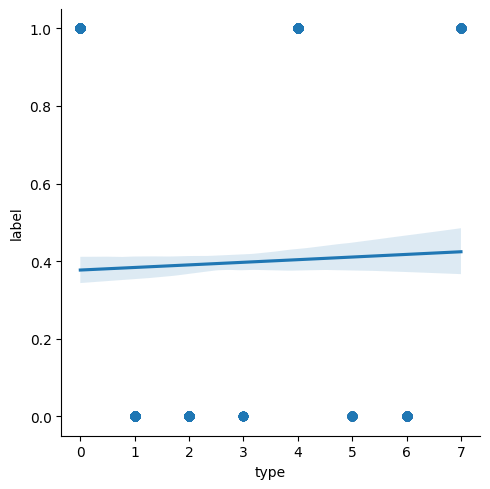

In [293]:
sns.lmplot(x='type', y='label', data=df_news, logistic=True, n_boot=100)

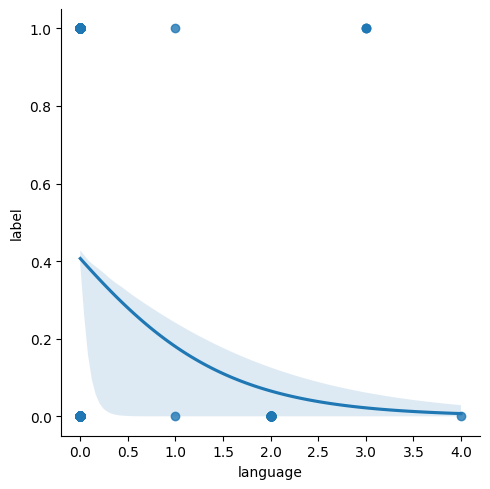

In [72]:
sns.lmplot(x='language', y='label', data=df_news, logistic=True, n_boot=100)

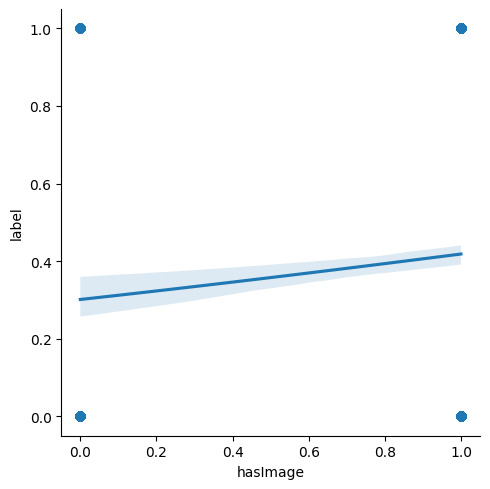

In [73]:
sns.lmplot(x='hasImage', y='label', data=df_news, logistic=True, n_boot=100)

<AxesSubplot: xlabel='language', ylabel='count'>

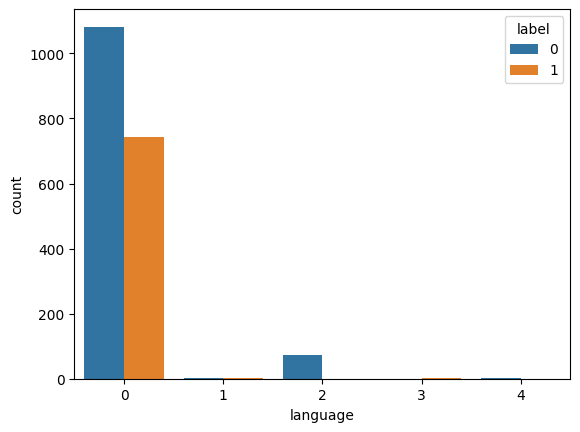

In [75]:
sns.countplot(x='language' , data=df_news, hue='label')

<AxesSubplot: xlabel='hasImage', ylabel='label'>

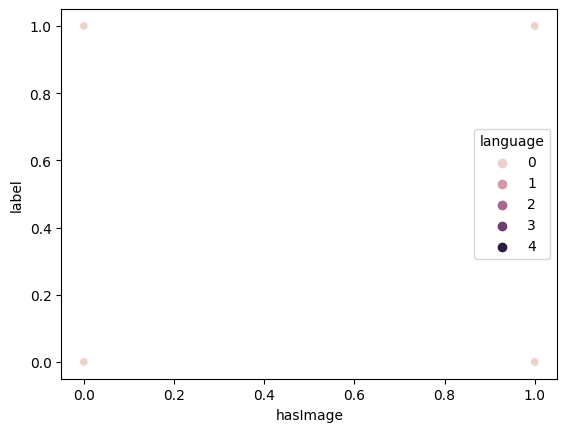

In [77]:
sns.scatterplot(x= df_news["hasImage"], y= df_news["label"], hue= df_news['language'])

In [80]:
#Joining X_res in just one column
X_res['text_combined'] = X_res["author"]+" " +X_res["site_url"] + " " + X_res["text_without_stopwords"]+" "+["text"]
X_res.drop(['author','site_url', 'text_without_stopwords','text'], axis = 1, inplace = True)
X_res=X_res.text_combined

In [81]:
X_res

0       barracuda brigade 100percentfedup.com print pa...
1       reasoning with facts 100percentfedup.com attor...
2       barracuda brigade 100percentfedup.com red stat...
3       fed up 100percentfedup.com email kayla mueller...
4       fed up 100percentfedup.com email healthcare re...
                              ...                        
2307    no author presstv.ir fms iran syria russia mee...
2308    bob unruh wnd.com print gappers team photo eve...
2309    staff davidduke.com httpmediaarchivesgsradione...
2310     rich hultén westernjournalism.com obamaland text
2311    daniel greenfield frontpagemag.com hillary cli...
Name: text_combined, Length: 2312, dtype: object

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [83]:
vectorizer =TfidfVectorizer()
vectorizer.fit(X_res)
X_res =vectorizer.transform(X_res)

In [84]:
X_res.shape

(2312, 46746)

In [85]:
print(X_res.toarray())

[[0.15018385 0.         0.         ... 0.         0.         0.        ]
 [0.05540086 0.         0.         ... 0.         0.         0.        ]
 [0.07807228 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
##normalize
##from sklearn .preprocessing import normalize
##neural_norm = normalize(df_news)
##neural_norm= pd.DataFrame(neural_norm, columns=df_news.columns)
##neural_norm.head()

In [88]:
##split the data 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size= 0.2, random_state = 32)

In [89]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [90]:
##  make the prediction
pred_LR = model_LR.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicted': pred_LR})

,Actual,Predicted
1397,1,1
567,0,0
1627,1,0
787,0,1
823,0,0
...,...,...
1243,0,1
867,0,0
987,1,1
2151,1,1


In [91]:
## evaluate the model accuracy
accuracy_LR = accuracy_score(y_test, pred_LR)

## CONFUSION MATRIX
conf_mat = confusion_matrix(y_test, pred_LR)

print(accuracy_LR)
print(conf_mat)

0.8790496760259179
[[211  35]
 [ 21 196]]


In [113]:
auc = roc_auc_score(y_test, pred_LR)
print('AUC: %f' %auc)

AUC: 0.880475


In [92]:
pd.DataFrame(confusion_matrix(y_test,pred_LR), columns=['Predicted No', 'Predicted Yes'],index =['Actual No', 'Actual Yes'])

,Predicted No,Predicted Yes
Actual No,211,35
Actual Yes,21,196


In [93]:
##Classification report 
from sklearn.metrics import classification_report

In [94]:
print(classification_report(y_test,pred_LR ))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       246
           1       0.85      0.90      0.88       217

    accuracy                           0.88       463
   macro avg       0.88      0.88      0.88       463
weighted avg       0.88      0.88      0.88       463



In [96]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
## random foresst regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=32)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=32)

In [99]:
rf_reg_pred = rf_reg.predict(X_test)

In [100]:
pd.DataFrame({'Actual': y_test, 'Predicted': rf_reg_pred})

,Actual,Predicted
1397,1,1.00
567,0,0.00
1627,1,1.00
787,0,0.01
823,0,0.00
...,...,...
1243,0,0.00
867,0,0.00
987,1,1.00
2151,1,1.00


In [112]:
auc = roc_auc_score(y_test,rf_reg_pred )
print('AUC: %f' %auc)

AUC: 0.991121


In [104]:
###decision tree 

Decision_tree_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5) 
Decision_tree_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5) 
Decision_tree_max_depth = DecisionTreeClassifier(max_depth=5)

In [105]:
## trainiong my models
Decision_tree_gini.fit(X_train,y_train)
Decision_tree_entropy.fit(X_train,y_train)
Decision_tree_max_depth.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [106]:
## make prediction
y_pred_gini = Decision_tree_gini.predict(X_test)
y_pred_entropy = Decision_tree_entropy.predict(X_test)
y_pred_depth3 = Decision_tree_max_depth.predict(X_test)

In [107]:
## make a dataframe prediction
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gini})

,Actual,Predicted
1397,1,1
567,0,0
1627,1,1
787,0,0
823,0,0
...,...,...
1243,0,0
867,0,0
987,1,1
2151,1,0


In [108]:
## make a dataframe prediction
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_entropy})

,Actual,Predicted
1397,1,1
567,0,0
1627,1,1
787,0,0
823,0,0
...,...,...
1243,0,0
867,0,0
987,1,1
2151,1,0


In [109]:
## make a dataframe prediction
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_depth3})

,Actual,Predicted
1397,1,1
567,0,0
1627,1,1
787,0,0
823,0,0
...,...,...
1243,0,0
867,0,0
987,1,1
2151,1,1


In [110]:
## model evaluation
## Evaluate the gini
accuracy_gini = accuracy_score(y_test, y_pred_gini)
conf_mat_gini = confusion_matrix(y_test, y_pred_gini)




print(accuracy_gini)
print(conf_mat_gini)

0.7365010799136069
[[245   1]
 [121  96]]


In [301]:
## Evaluate the entropy
accuracy_entropy = accuracy_score(y_test, y_pred_entropy)
conf_mat_entropy = confusion_matrix(y_test, y_pred_entropy)


print(accuracy_entropy)
print(conf_mat_entropy)

0.734341252699784
[[245   1]
 [122  95]]


In [302]:
## Evaluate the max_depth
accuracy_max_depth = accuracy_score(y_test, y_pred_depth3)
conf_mat_max_depth = confusion_matrix(y_test, y_pred_depth3)


print(accuracy_max_depth)
print(conf_mat_max_depth)

0.8617710583153347
[[245   1]
 [ 63 154]]


In [115]:
auc = roc_auc_score(y_test,y_pred_depth3 )
print('AUC: %f' %auc)

AUC: 0.864327


In [56]:
## SVM
#Create a SVM Classifier
clfLinear = svm.SVC(kernel='linear')
clfsigmoid = svm.SVC(kernel='sigmoid') 



In [58]:
#Train the model using the training sets

clfsigmoid.fit(X_train, y_train)

SVC(kernel='sigmoid')

In [59]:
clfLinear.fit(X_train, y_train)

SVC(kernel='linear')

In [60]:
y_pred_linear = clfLinear.predict(X_test)
y_pred_sigmoid = clfsigmoid.predict(X_test)

In [61]:
## make a dataframe prediction for linear kernel
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_linear})

,Actual,Predicted
1397,1,1
567,0,0
1627,1,0
787,0,1
823,0,0
...,...,...
1243,0,1
867,0,0
987,1,1
2151,1,0


In [62]:
## make a dataframe prediction for linear kernel
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_sigmoid})

,Actual,Predicted
1397,1,1
567,0,0
1627,1,0
787,0,1
823,0,0
...,...,...
1243,0,1
867,0,0
987,1,1
2151,1,0


In [63]:
#Calculate the accuracy of our model
print("Linear Kernel Accuracy:",metrics.accuracy_score(y_test, y_pred_linear))
print("Sigmoid kernel Accuracy:",metrics.accuracy_score(y_test, y_pred_sigmoid))

Linear Kernel Accuracy: 0.8833693304535637
Sigmoid kernel Accuracy: 0.8812095032397408


In [66]:
auc = roc_auc_score(y_test, y_pred_linear)
print('AUC: %f' %auc)

AUC: 0.883182


In [51]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1904 entries, 0 to 2048
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   author                  1904 non-null   object 
 1   text                    1904 non-null   object 
 2   language                1904 non-null   object 
 3   site_url                1904 non-null   object 
 4   main_img_url            1904 non-null   object 
 5   type                    1904 non-null   int32  
 6   label                   1904 non-null   int32  
 7   text_without_stopwords  1904 non-null   object 
 8   hasImage                1904 non-null   float64
dtypes: float64(1), int32(2), object(6)
memory usage: 198.4+ KB


In [ ]:
##If we want our model to make predictions based on text data, then we need to convert it to vector format, where ir can be processed by our computers. 
##Count Vectorizer and TF-IDF
#TF-IDF is better than Count Vectorizer because it not only focuses on the frecuency of words presente in the corpus.
##but also provides the importance of the words.